In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
import joblib

In [ ]:
def eval_metrics(y_true, y_pred, y_proba=None):
    d = {}
    d['accuracy'] = accuracy_score(y_true, y_pred)
    d['precision'] = precision_score(y_true, y_pred, zero_division=0, average='binary')
    d['recall'] = recall_score(y_true, y_pred, zero_division=0, average='binary')
    d['f1'] = f1_score(y_true, y_pred, zero_division=0, average='binary')
    if y_proba is not None:
        d['roc_auc'] = roc_auc_score(y_true, y_proba)
    else:
        d['roc_auc'] = np.nan
    return d

def plot_roc(y_test, proba, label):
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_score(y_test, proba):.3f})")

In [3]:
pca_path = "C:/Users/pc/Downloads/heart_pca.csv"         # PCA file (n PCs + num)
sel_path = "C:/Users/pc/Downloads/heart_selected.csv"    # Selected features + num

df_pca = pd.read_csv(pca_path)
df_sel = pd.read_csv(sel_path)

print("PCA shape:", df_pca.shape)
print("Selected shape:", df_sel.shape)

PCA shape: (297, 11)
Selected shape: (297, 7)


In [4]:
# Convert multi-class target to binary (0=no disease, 1=disease)
for df in (df_pca, df_sel):
    if df['num'].nunique() > 2:
        df['num'] = (df['num'] > 0).astype(int)

Evaluating PCA dataset...


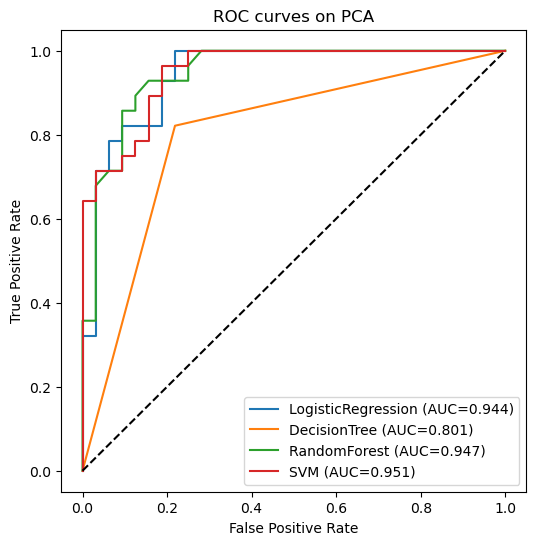

Evaluating Selected-features dataset...


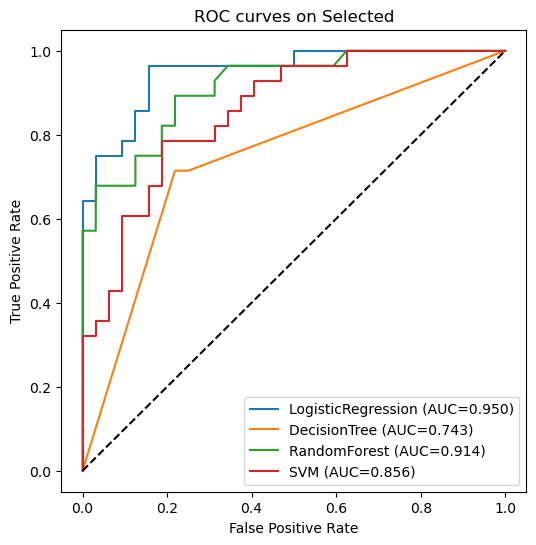

In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

def train_eval_dataset(df, dataset_name="dataset"):
    X = df.drop(columns=['num'])
    y = df['num']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
    models = {
        "LogisticRegression": LogisticRegression(max_iter=2000, random_state=RANDOM_STATE),
        "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
        "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
        "SVM": SVC(probability=True, random_state=RANDOM_STATE)
    }
    results = {}
    plt.figure(figsize=(6,6))
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:,1]
        else:  # fallback for models without predict_proba
            y_proba = model.decision_function(X_test)
            # scale to 0-1
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min() + 1e-12)
        metrics = eval_metrics(y_test, y_pred, y_proba)
        results[name] = metrics
        plot_roc(y_test, y_proba, name)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curves on {dataset_name}")
    plt.legend()
    plt.show()
    return results

print("Evaluating PCA dataset...")
res_pca = train_eval_dataset(df_pca, "PCA")
print("Evaluating Selected-features dataset...")
res_sel = train_eval_dataset(df_sel, "Selected")


In [7]:
print("---- PCA results ----")
display(pd.DataFrame(res_pca).T.round(3))

print("\n---- Selected features results ----")
display(pd.DataFrame(res_sel).T.round(3))

---- PCA results ----


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.850,0.852,0.821,0.836,0.944
DecisionTree,0.800,0.767,0.821,0.793,0.801
RandomForest,0.850,0.880,0.786,0.830,0.947
SVM,0.833,0.846,0.786,0.815,0.951



---- Selected features results ----


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.833,0.875,0.750,0.808,0.950
DecisionTree,0.750,0.741,0.714,0.727,0.743
RandomForest,0.817,0.840,0.750,0.792,0.914
SVM,0.750,0.760,0.679,0.717,0.856


In [8]:
# The PCA data set gives the high performance
X_sel = df_pca.drop(columns=['num'])
y_sel = df_pca['num']

X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y_sel, test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, stratify=y_sel
)

# Train Logistic Regression
best_model = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)
best_model.fit(X_train, y_train)

# Save final model
joblib.dump(best_model, "C:/Users/pc/Downloads/Heart_Disease_Project/models/final_model.pkl")

print("✅ Saved final Logistic Regression model to models/final_model.pkl")

✅ Saved final Logistic Regression model to models/final_model.pkl
